### Download data

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "data_folder/sms_spam_collection.zip"
extracted_path = "data_folder/sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

data_folder/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


### Preprocess the data

In [2]:
import pandas as pd

df = pd.read_csv("data_folder/sms_spam_collection/SMSSpamCollection.tsv", sep="\t", header=None, names=["target", "text"])

# Balance the dataset
spam_df= df[df["target"] == "spam"]
ham_df = df[df["target"] == "ham"]

balanced_df = pd.concat([spam_df, ham_df.sample(len(spam_df))])

# map spam and ham to 1 and 0
balanced_df["target"] = balanced_df["target"].map(lambda x: 1 if x == "spam" else 0)

### Split data on train, val and test

In [3]:
import numpy as np

train_ratio = 0.7
val_ratio = 0.1

train_index = int(len(balanced_df) * train_ratio)
val_index = int(len(balanced_df) * (train_ratio + val_ratio))

balanced_df = balanced_df.sample(frac=1, replace=False, random_state=3042025).reset_index(drop=True)

train = balanced_df[:train_index].reset_index(drop=True)
val = balanced_df[train_index:val_index].reset_index(drop=True)
test = balanced_df[val_index:].reset_index(drop=True)


### Create Datasets

In [4]:
from typing import Any

import tiktoken
import torch
from torch.utils.data import Dataset

tokenizer = tiktoken.get_encoding("gpt2")
# print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})) # 50256



class SpamDataset(Dataset):
    def __init__(self, data: pd.DataFrame, pad_token_id=50256, max_len=None) -> None:
        self.data = data

        self.encoded_text = [tokenizer.encode(text) for text in self.data["text"]]

        if max_len is not None:
            self.max_len = max_len
            self.encoded_text = [text[:max_len] for text in self.encoded_text]
        else:
            self.max_len = self._longest_encoded_length()
            self.encoded_text = [text + [pad_token_id] * (self.max_len - len(text)) 
                                 for text in self.encoded_text]
    

    def _longest_encoded_length(self) -> int:
        max_len = max([len(t) for t in self.encoded_text])
        return max_len


    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index) -> Any:
        encoded = self.encoded_text[index]
        target = self.data.loc[index, "target"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(target, dtype=torch.long),
        )
        
    
train_dataset = SpamDataset(train, max_len=None)
val_dataset = SpamDataset(val, max_len=None)
test_dataset = SpamDataset(test, max_len=None)


### Create Dataloaders

In [5]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(3042025)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True, # If your dataset has 100 samples with batch size 30, you'll get 3 batches (30, 30, 30) and the remaining 10 samples will be dropped
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

### Initializing a model with pretrained weights

In [6]:
import os
import urllib.request

from safetensors.torch import load_file
from src.config import BASE_CONFIG, CHOOSE_MODEL, model_configs
from src.model import GPTModel, load_weights_into_gpt


BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

URL_DIR = {
    "gpt2-small (124M)": "gpt2",  # works ok
    "gpt2-medium (355M)": "gpt2-medium",  # this file seems to have issues via `generate`
    "gpt2-large (774M)": "gpt2-large",  # works ok
    "gpt2-xl (1558M)": "gpt2-xl",  # works ok
}

url = f"https://huggingface.co/openai-community/{URL_DIR[CHOOSE_MODEL]}/resolve/main/model.safetensors"
output_file = f"model-{URL_DIR[CHOOSE_MODEL]}.safetensors"

# Download file
if not os.path.exists(output_file):
    print(f"Downloading {url} to {output_file}")
    urllib.request.urlretrieve(url, output_file)

# Load weights
print("Loading weights")
state_dict = load_file(output_file)
model = GPTModel(BASE_CONFIG)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Loading weights into GPT")
load_weights_into_gpt(model, state_dict)
model.eval()

Loading weights
Loading weights into GPT


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

### Check if weights are loaded correctly

In [7]:
from src.utils import generate, token_ids_to_text, text_to_token_ids

token_ids = generate(
        model=model.to(device),
        idx=text_to_token_ids("Every effort moves", tokenizer).to(device),
        max_new_tokens=30,
        context_size=BASE_CONFIG["context_length"],
        top_k=1,
        temperature=1.0,
    )

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not going to do this,'


### Add a classification head

In [8]:
# freeze all params
for param in model.parameters():
    param.requires_grad = False

num_classes = df["target"].nunique()
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

# finetuning additional layers can noticeably improve the performance
# so lets also train the last transformer block and final LayerNorm module
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

### Check the model

In [9]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)

print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

with torch.no_grad():
    outputs = model(inputs.to(device))

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-1.6126, -1.3847],
         [-9.1227, -9.3969],
         [-6.7019, -8.5012],
         [-4.3245, -4.4443]]], device='cuda:0')
Outputs dimensions: torch.Size([1, 4, 2])


### Function for accuracy metric calculation

In [10]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (text_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        text_batch, target_batch = text_batch.to(device), target_batch.to(device)
        num_examples += 1

        with torch.no_grad():
            logits = model(text_batch)[:, -1, :] # batch size, text len, output dim

        predicted_label = torch.argmax(logits, dim=-1)

        num_examples += predicted_label.shape[0]
        correct_predictions += (predicted_label == target_batch).sum().item()

    return correct_predictions / num_examples


calc_accuracy_loader(train_dataloader, model, device, num_batches=20)


0.4777777777777778

### Function for loss calculation

In [11]:
def calc_loss_batch(text_batch, target_batch, model, device):
    text_batch, target_batch = text_batch.to(device), target_batch.to(device)
    logits = model(text_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    model.eval()
    total_loss, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (text_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        num_examples += 1

        total_loss += calc_loss_batch(text_batch, target_batch, model, device)

    return total_loss / num_examples

calc_loss_loader(train_dataloader, model, device, num_batches=10)

tensor(1.0660, device='cuda:0', grad_fn=<DivBackward0>)

### Train classifier

In [12]:
import time

def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.919, Val loss 0.987
Ep 1 (Step 000050): Train loss 0.668, Val loss 0.650
Ep 1 (Step 000100): Train loss 0.586, Val loss 0.595
Training accuracy: 71.11% | Validation accuracy: 62.22%
Ep 2 (Step 000150): Train loss 0.444, Val loss 0.472
Ep 2 (Step 000200): Train loss 0.519, Val loss 0.418
Ep 2 (Step 000250): Train loss 0.474, Val loss 0.493
Training accuracy: 82.22% | Validation accuracy: 68.89%
Ep 3 (Step 000300): Train loss 0.365, Val loss 0.422
Ep 3 (Step 000350): Train loss 0.299, Val loss 0.507
Training accuracy: 77.78% | Validation accuracy: 80.00%
Ep 4 (Step 000400): Train loss 0.198, Val loss 0.234
Ep 4 (Step 000450): Train loss 0.138, Val loss 0.161
Ep 4 (Step 000500): Train loss 0.285, Val loss 0.120
Training accuracy: 80.00% | Validation accuracy: 84.44%
Ep 5 (Step 000550): Train loss 0.100, Val loss 0.104
Ep 5 (Step 000600): Train loss 0.093, Val loss 0.087
Training accuracy: 86.67% | Validation accuracy: 86.67%
Training completed in 0.86 minu

### Plot the result

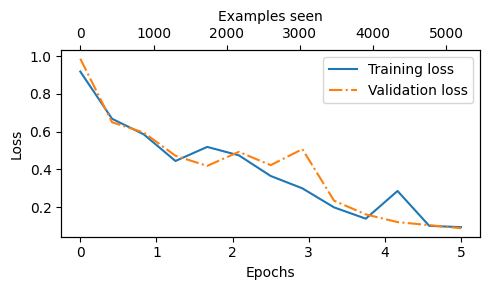

In [13]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

train_losses = [l.to("cpu") for l in train_losses]
val_losses = [l.to("cpu") for l in val_losses]

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

### Use model as spam classifier

In [14]:

def classify_text(text, model, tokenizer, device, max_len, pad_token_id=50256):
    model.eval()
    
    input = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Truncate sequences if they too long
    input = input[:min(max_len, supported_context_length)]

    # Pad sequences to the longest sequence
    input += [pad_token_id] * (max_len - len(input))
    input = torch.tensor(input, device=device).unsqueeze(0) # add batch dimension

    with torch.no_grad():
        logits = model(input)[:, -1, :]
    prediction = torch.argmax(logits, dim=-1).squeeze(0)

    return "spam" if prediction == 1 else "not spam"

text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)


print(classify_text(text_1, model, tokenizer, device, max_len=train_dataset.max_len))
print(classify_text(text_2, model, tokenizer, device, max_len=train_dataset.max_len))

spam
not spam


### Save the model

In [16]:
torch.save(model.state_dict(), "data_folder/review_classifier.pth")

# 